# Choice-based conjoint analysis

## The tool of choice to discover:
* Customer preferences of product attribute profiles
* Customer sensitivity to price
* Priority setting for product development
* Simulation of product success before launch

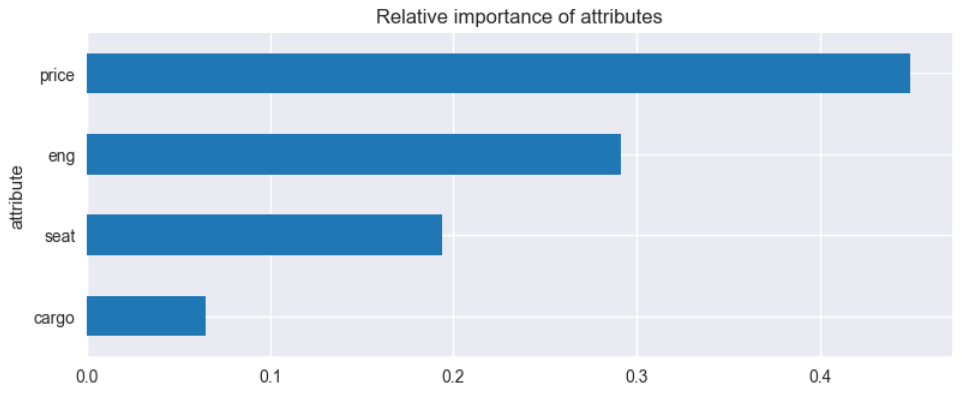

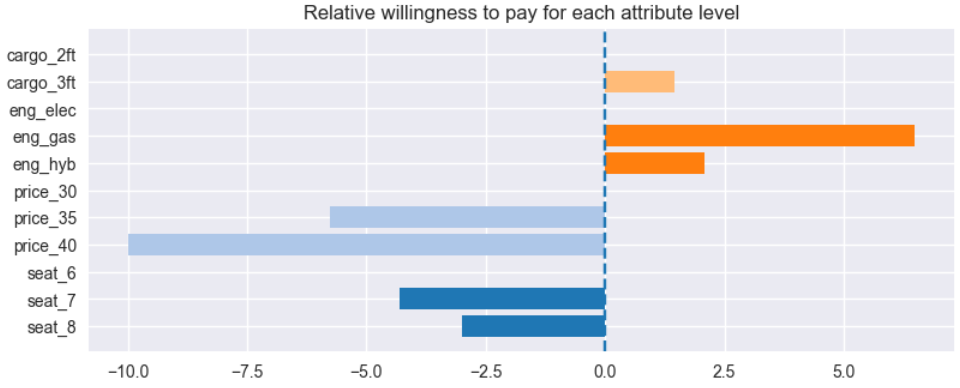

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # Graphics (normal)
from cycler import cycler

plt.style.use('seaborn-v0_8') # Style for matplotlib charts (optional, but makes easier to read charts)
plt.rcParams['figure.figsize'] = [9.3, 3.5] # Size for matplotlib charts (optional, but useful) 
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.get_cmap('tab20').colors)  #tab20b

from sklearn.compose import ColumnTransformer # Pipeline to transform columns of a dataframe
from sklearn.preprocessing import OneHotEncoder # create dummy variables

import statsmodels.api as sm # Create regression model

# Importing survey data

In [2]:
survey_data = pd.read_csv(r'conjoint.csv')

## EDA
Exploratory data analysis

In [3]:
survey_data

,resp.id,ques,alt,carpool,seat,cargo,eng,price,choice
0,1,1,1,yes,6,2ft,gas,35,0
1,1,1,2,yes,8,3ft,hyb,30,0
2,1,1,3,yes,6,3ft,gas,30,1
3,1,2,1,yes,6,2ft,gas,30,0
4,1,2,2,yes,7,3ft,gas,35,1
...,...,...,...,...,...,...,...,...,...
8995,200,14,2,no,7,3ft,gas,35,1
8996,200,14,3,no,7,3ft,hyb,35,0
8997,200,15,1,no,7,2ft,gas,35,0
8998,200,15,2,no,8,3ft,elec,40,0


### Checking answers

In [4]:
survey_data.groupby(['resp.id', 'ques']).choice.sum()

resp.id  ques
1        1       1
         2       1
         3       1
         4       1
         5       1
                ..
200      11      1
         12      1
         13      1
         14      1
         15      1
Name: choice, Length: 3000, dtype: int64

#### Repeated answers?

The following value should be higher than 1 to show repeated answers.

Repeated answers are not allowed (if questions properly chosen), something happened along the survey process.

In [5]:
survey_data.groupby(['resp.id', 'ques']).choice.sum().max()

1

#### Are there answers of type 'None of the options'?

This is allowed, and the following value should be 0 to show this.

When survey allows the answer 'None of the options', it just means that choice is 0 for all alternatives for this particular question and resp.id

In [6]:
survey_data.groupby(['resp.id', 'ques']).choice.sum().min()

1

### Checking NaNs and data types

In [7]:
survey_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   resp.id  9000 non-null   int64 
 1   ques     9000 non-null   int64 
 2   alt      9000 non-null   int64 
 3   carpool  9000 non-null   object
 4   seat     9000 non-null   int64 
 5   cargo    9000 non-null   object
 6   eng      9000 non-null   object
 7   price    9000 non-null   int64 
 8   choice   9000 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 632.9+ KB


In [ ]:
No NaN detected

### Check duplicated rows

In [8]:
survey_data.duplicated().sum()

0

No duplicated rows detected

### Discover attributes and attribute levels

In [9]:
survey_data.columns

Index(['resp.id', 'ques', 'alt', 'carpool', 'seat', 'cargo', 'eng', 'price',
       'choice'],
      dtype='object')

In [10]:
print('Unique values for columns:')
for column in ['ques', 'alt', 'carpool', 'seat', 'cargo', 'eng', 'price', 'choice']:
    print(f'{column}: {np.sort( survey_data[column].unique() )}')

Unique values for columns:
ques: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
alt: [1 2 3]
carpool: ['no' 'yes']
seat: [6 7 8]
cargo: ['2ft' '3ft']
eng: ['elec' 'gas' 'hyb']
price: [30 35 40]
choice: [0 1]


* Number of choices: 0 or 1 (choice-based conjoint analysis)
* Number of attributes: 4
    * Number of levels: 3 for seat, 2 for cargo, 3 for eng, 3 for price
* Number of questions: 15
    * Number of alternatives for each question: 3 (in this case, a 'none of the options' option was not considered)
* Column carpool is used to segment customers

### Get insights of survey answers

In [11]:
for column in ['seat', 'cargo', 'eng', 'price']:
    print(f'Survey results for: {column}')
    display(survey_data.groupby([column, 'choice']).choice.count().unstack(fill_value=0))
    print()

Survey results for: seat


choice,0,1
seat,,
6,1860,1164
7,2139,854
8,2001,982



Survey results for: cargo


choice,0,1
cargo,,
2ft,3189,1312
3ft,2811,1688



Survey results for: eng


choice,0,1
eng,,
elec,2402,608
gas,1561,1444
hyb,2037,948



Survey results for: price


choice,0,1
price,,
30,1512,1486
35,2041,956
40,2447,558


# Create model

Create a work on a copy of the original data

In [12]:
df = survey_data.copy()

## Defining custom reference levels

It could be done in different ways.

This way gives very high flexibility for user.

In [13]:
reference_levels = {
    'seat': 6,
    'cargo': '2ft',
    'eng': 'elec',
    'price': 30
}

## Encoding data
Preparing dummy variables

In [14]:
# This will create dummy columns for each attribute
# using the reference level defined in reference_levels
onehot_column_transformers = [
    (
        f"onehot_{column}", 
        OneHotEncoder(drop=[drop_value], sparse_output=False), 
        [column]
    )
    for column, drop_value in reference_levels.items()
]

# Creating the dummy columns
# First it will be a numpy array
column_transformer = ColumnTransformer(onehot_column_transformers)

encoded = column_transformer.fit_transform(df)

# Converting numpy array into pandas dataframe with proper column name
column_names = []
for name, transformer, cols in column_transformer.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        column_names.extend(transformer.get_feature_names_out(cols))

# Convert encoded array to DataFrame with proper column names
encoded_df = pd.DataFrame(encoded, columns=column_names)

print(encoded_df)


      seat_7  seat_8  cargo_3ft  eng_gas  eng_hyb  price_35  price_40
0        0.0     0.0        0.0      1.0      0.0       1.0       0.0
1        0.0     1.0        1.0      0.0      1.0       0.0       0.0
2        0.0     0.0        1.0      1.0      0.0       0.0       0.0
3        0.0     0.0        0.0      1.0      0.0       0.0       0.0
4        1.0     0.0        1.0      1.0      0.0       1.0       0.0
...      ...     ...        ...      ...      ...       ...       ...
8995     1.0     0.0        1.0      1.0      0.0       1.0       0.0
8996     1.0     0.0        1.0      0.0      1.0       1.0       0.0
8997     1.0     0.0        0.0      1.0      0.0       1.0       0.0
8998     0.0     1.0        1.0      0.0      0.0       0.0       1.0
8999     0.0     0.0        1.0      1.0      0.0       1.0       0.0

[9000 rows x 7 columns]


## Creating the regression model

$$
P(\text{choice} = 1 \mid X) = \frac{1}{1 + \exp\left(-\sum_{j=1}^{k} \beta_j x_j\right)}
$$

model_results.params are the betas

model_results.predict(encoded_df.iloc[3]) will return a probability value (between 0 and 1), corresponding to: probability to pick (aka probabilitiy of success) given that X has been chosen.

To transform this prediction into an y value (pick/no pick), you can define a threshold value, above which pick can be accepted, for instance P>0.5

In [15]:
y = df.choice
X = encoded_df

# For choice-set data, the standard Logit model in statsmodels, when applied
# to the stacked format (where the intercept is dropped), functions as the MNL.

model = sm.Logit(y, X, offset=None)  # Very important that there is no free coefficient
model_results = model.fit(disp=False)

In [16]:
print(model_results.summary())

                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                 9000
Model:                          Logit   Df Residuals:                     8993
Method:                           MLE   Df Model:                            6
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                  0.1135
Time:                        21:30:31   Log-Likelihood:                -5078.2
converged:                       True   LL-Null:                       -5728.6
Covariance Type:            nonrobust   LLR p-value:                7.233e-278
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
seat_7        -0.7704      0.054    -14.292      0.000      -0.876      -0.665
seat_8        -0.5365      0.053    -10.174      0.000      -0.640      -0.433
cargo_3ft      0.2575      0.045      5.730      0.0

Comments:
* Model could have a higher pseudo R-squared value (above 0.2), no means to improve model in this example
* LLR p-value seems anyway fine
* All coefficients have a very low p value, therefore are relevant
* Confidence intervals for coefficients could be reduced by increasing survey data, no further analysis of confidence intervals for the obtained results will be done, apart from this heuristic approach: if these CIs are fine, results are fine.

# Results

Model calculates the coefficients related to the attribute levels.

Remembering that there are more levels, which were considered as reference ones.

These reference levels are considered as having parameters set to 0

In [17]:
# Pick part worth from the model coefficients
part_worth = (model_results.params) 

# Format referent level names according current nomenclature
reference_levels_list = [f"{key}_{value}" for key, value in reference_levels.items()]

# Assing 0 to reference levels
reference_levels_part_worth_0 = [0] * len(reference_levels_list)

reference_levels_part_worth = pd.Series(reference_levels_part_worth_0, index=reference_levels_list)

# Put all together and sorted
part_worth = pd.concat([part_worth, reference_levels_part_worth]).sort_index()

In [18]:
part_worth

cargo_2ft    0.000000
cargo_3ft    0.257519
eng_elec     0.000000
eng_gas      1.156898
eng_hyb      0.374210
price_30     0.000000
price_35    -1.027254
price_40    -1.784697
seat_6       0.000000
seat_7      -0.770431
seat_8      -0.536520
dtype: float64

## Results of part worth related to attribute and attribute levels

In [19]:
part_worth_df = part_worth.reset_index()
part_worth_df[['attribute', 'level']] = part_worth_df['index'].str.split('_', expand=True)
part_worth_df = part_worth_df.drop(columns='index')

# Rename value column
part_worth_df = part_worth_df.rename(columns={0: 'part_worth'})

# Reorder columns
part_worth_df = part_worth_df[['attribute', 'level', 'part_worth']]

display(part_worth_df)

,attribute,level,part_worth
0,cargo,2ft,0.000000
1,cargo,3ft,0.257519
2,eng,elec,0.000000
3,eng,gas,1.156898
4,eng,hyb,0.374210
5,price,30,0.000000
6,price,35,-1.027254
7,price,40,-1.784697
8,seat,6,0.000000
9,seat,7,-0.770431


### Visually

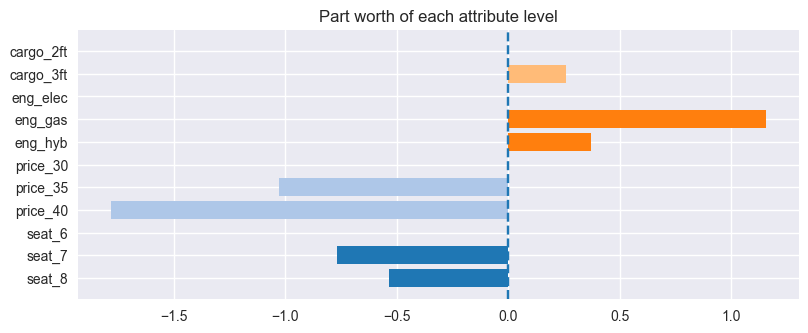

,attribute,level,part_worth
0,cargo,2ft,0.000000
1,cargo,3ft,0.257519
2,eng,elec,0.000000
3,eng,gas,1.156898
4,eng,hyb,0.374210
5,price,30,0.000000
6,price,35,-1.027254
7,price,40,-1.784697
8,seat,6,0.000000
9,seat,7,-0.770431


In [20]:
part_worth_df_chart = part_worth_df.copy()

part_worth_df_chart['label'] = part_worth_df.attribute + '_' + part_worth_df.level

part_worth_df_chart = part_worth_df_chart.sort_values(by='label', ascending=False)

# Create a color map for each attribute
unique_attrs = part_worth_df_chart['attribute'].unique()
color_map = dict(zip(unique_attrs, plt.cm.tab20.colors[:len(unique_attrs)]))

# Map colors to each row
colors = part_worth_df_chart['attribute'].map(color_map)

plt.barh(y=part_worth_df_chart.label, width=part_worth_df_chart.part_worth, color=colors)
plt.axvline(x=0, linestyle='--')
plt.title('Part worth of each attribute level')
plt.show()
display(part_worth_df)

## Results of attribute importance

For each attribute a
$$
\text{Relative Importance}_a = \frac{\text{Range}_a}{\sum_{i} \text{Range}_i}
$$

In [21]:
attribute_importance = part_worth_df.groupby('attribute').agg(
                                    part_worth_min=('part_worth', 'min'),
                                    part_worth_max=('part_worth', 'max')
                                    )
attribute_importance['importance'] = np.abs(
                    attribute_importance.part_worth_max - attribute_importance.part_worth_min
                    )

total_importance = attribute_importance.importance.sum()
attribute_importance['importance_relative'] = attribute_importance.importance / total_importance

### Visually

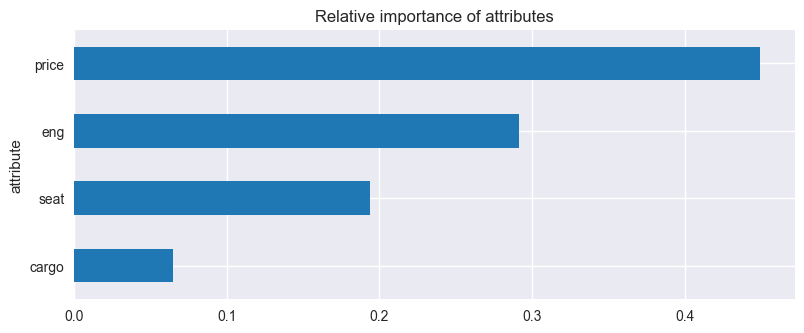

,part_worth_min,part_worth_max,importance,importance_relative
attribute,,,,
price,-1.784697,0.000000,1.784697,0.449597
eng,0.000000,1.156898,1.156898,0.291443
seat,-0.770431,0.000000,0.770431,0.194085
cargo,0.000000,0.257519,0.257519,0.064874


In [22]:
attribute_importance.importance_relative.sort_values().plot(kind='barh')
plt.title('Relative importance of attributes')
plt.show()
display(attribute_importance.sort_values(by='importance_relative', ascending=False))

## Best product profiles

Best products profiles have the highest utility

utility is the sum of the corresponding part worths for each product profile

In [23]:
df.columns

Index(['resp.id', 'ques', 'alt', 'carpool', 'seat', 'cargo', 'eng', 'price',
       'choice'],
      dtype='object')

Create dataframe to calculate utility

In [24]:
utilities = []
# Sorting lists makes easier to check code results
for seat_unique in sorted(df.seat.unique().tolist()):
    for cargo_unique in sorted(df.cargo.unique().tolist()):
        for eng_unique in sorted(df.eng.unique().tolist()):
            for price_unique in sorted(df.price.unique().tolist()):
                utilities_dict = {
                    'seat': seat_unique,
                    'cargo': cargo_unique,
                    'eng': eng_unique,
                    'price': price_unique                    
                    }
                utilities.append(utilities_dict)

utilities_df = pd.DataFrame(utilities)

Comment:

There is a more pythonic way of doing that, which enables easier increase/decrease of attributes:

from itertools import product

seat_vals = sorted(df['seat'].unique())
cargo_vals = sorted(df['cargo'].unique())
eng_vals = sorted(df['eng'].unique())
price_vals = sorted(df['price'].unique())

combinations = product(seat_vals, cargo_vals, eng_vals, price_vals)

utilities_df = pd.DataFrame(combinations, columns=['seat', 'cargo', 'eng', 'price'])

Include part worth for each attribute level, which is its partial utility

In [25]:
for attribute in utilities_df.columns.tolist():  # exclude non-attribute columns like 'choice'
    attribute_pw = part_worth_df[part_worth_df['attribute'] == attribute]

    # Match each value in utilities_df[attribute] to its part-worth
    utilities_df[f'utility_{attribute}'] = [
        attribute_pw.loc[attribute_pw['level'] == str(val), 'part_worth'].values[0]
        for val in utilities_df[attribute]
    ]

Calculate utility, which is the sum of the utility for each attribute level

In [26]:
utilities_df['utility'] = utilities_df.filter(like='utility_').sum(axis=1)

Showing most wanted attribute profiles, according to survey, in descending order

In [27]:
utilities_df.sort_values(by='utility', ascending=False)

,seat,cargo,eng,price,utility_seat,utility_cargo,utility_eng,utility_price,utility
12,6,3ft,gas,30,0.000000,0.257519,1.156898,0.000000,1.414417
3,6,2ft,gas,30,0.000000,0.000000,1.156898,0.000000,1.156898
48,8,3ft,gas,30,-0.536520,0.257519,1.156898,0.000000,0.877897
30,7,3ft,gas,30,-0.770431,0.257519,1.156898,0.000000,0.643986
15,6,3ft,hyb,30,0.000000,0.257519,0.374210,0.000000,0.631730
39,8,2ft,gas,30,-0.536520,0.000000,1.156898,0.000000,0.620378
13,6,3ft,gas,35,0.000000,0.257519,1.156898,-1.027254,0.387164
21,7,2ft,gas,30,-0.770431,0.000000,1.156898,0.000000,0.386467
6,6,2ft,hyb,30,0.000000,0.000000,0.374210,0.000000,0.374210
9,6,3ft,elec,30,0.000000,0.257519,0.000000,0.000000,0.257519


### Best product profile (market) shares

If only the products of this portfolio existed in the market, that would be its market share.

Please consider these results as orientative for a better understanding of attribute mixes, as competition or other external factors can strongly affect these results

$$
\text{share}_i = \frac{e^{utility_i}}{\sum_{j} e^{utility_j}}
$$


In [28]:
utilities_df['exp_utility'] = np.exp(utilities_df.utility)

total_exp_utility = utilities_df.exp_utility.sum()
utilities_df['share'] = utilities_df.exp_utility / total_exp_utility

In [29]:
utilities_df.sort_values(by='utility', ascending=False)

,seat,cargo,eng,price,utility_seat,utility_cargo,utility_eng,utility_price,utility,exp_utility,share
12,6,3ft,gas,30,0.000000,0.257519,1.156898,0.000000,1.414417,4.114087,0.101900
3,6,2ft,gas,30,0.000000,0.000000,1.156898,0.000000,1.156898,3.180053,0.078765
48,8,3ft,gas,30,-0.536520,0.257519,1.156898,0.000000,0.877897,2.405835,0.059589
30,7,3ft,gas,30,-0.770431,0.257519,1.156898,0.000000,0.643986,1.904056,0.047161
15,6,3ft,hyb,30,0.000000,0.257519,0.374210,0.000000,0.631730,1.880861,0.046586
39,8,2ft,gas,30,-0.536520,0.000000,1.156898,0.000000,0.620378,1.859630,0.046060
13,6,3ft,gas,35,0.000000,0.257519,1.156898,-1.027254,0.387164,1.472797,0.036479
21,7,2ft,gas,30,-0.770431,0.000000,1.156898,0.000000,0.386467,1.471772,0.036454
6,6,2ft,hyb,30,0.000000,0.000000,0.374210,0.000000,0.374210,1.453843,0.036010
9,6,3ft,elec,30,0.000000,0.257519,0.000000,0.000000,0.257519,1.293717,0.032043


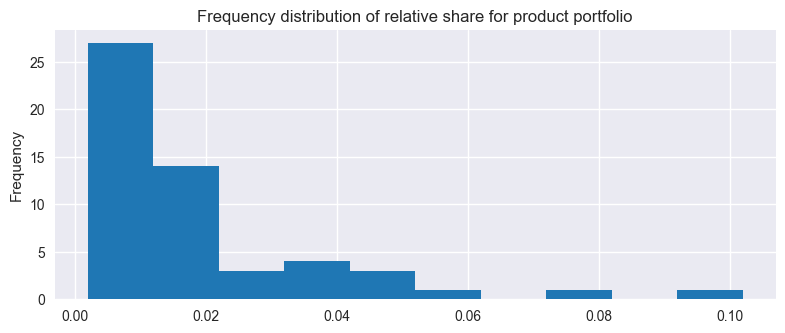

In [30]:
utilities_df.share.plot(kind='hist')
plt.title('Frequency distribution of relative share for product portfolio')
plt.show()

# Calculate willingness to pay

$$
\text{WTP}_{\text{Level }k} = \frac{\beta_{\text{Level }k}}{\beta_{\text{Price}}}
$$

For this case, where price is not a continuous function (and its value would come directly from the regression model): 

$$
\frac{1}{\beta_{\text{Price}}} = -\frac{\text{Highest Price} - \text{Lowest Price}}{\beta_{\text{Highest Price Level}} - \beta_{\text{Lowest Price Level}}}
$$

In [31]:
price_level_max = part_worth_df.loc[part_worth_df['attribute'] == 'price', 'level'].max()
price_level_min = part_worth_df.loc[part_worth_df['attribute'] == 'price', 'level'].min()

beta_price_level_max = part_worth_df.loc[( (part_worth_df.attribute == 'price') & (
                                           part_worth_df.level == price_level_max) 
                                         )].part_worth.values[0]
beta_price_level_min = part_worth_df.loc[( (part_worth_df.attribute == 'price') & (
                                           part_worth_df.level == price_level_min) 
                                         )].part_worth.values[0]

beta_price_approximated = - (beta_price_level_max - beta_price_level_min) / (
                            float(price_level_max) - float(price_level_min)) #Make sure that values are not categories

In [32]:
part_worth_df['willingness_to_pay'] = part_worth_df.part_worth/beta_price_approximated

## Visually

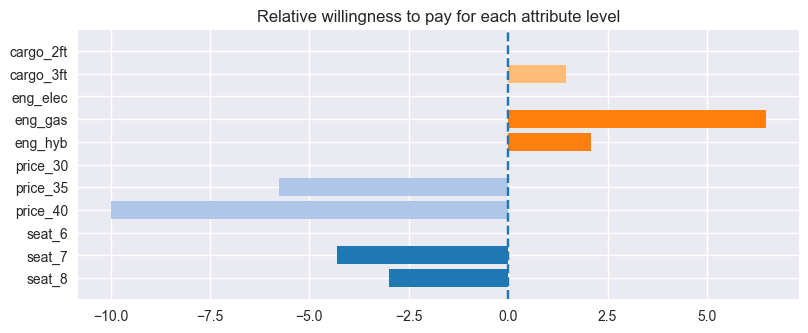

,attribute,level,part_worth,willingness_to_pay
0,cargo,2ft,0.000000,0.000000
1,cargo,3ft,0.257519,1.442930
2,eng,elec,0.000000,0.000000
3,eng,gas,1.156898,6.482321
4,eng,hyb,0.374210,2.096773
5,price,30,0.000000,0.000000
6,price,35,-1.027254,-5.755900
7,price,40,-1.784697,-10.000000
8,seat,6,0.000000,0.000000
9,seat,7,-0.770431,-4.316872


In [33]:
part_worth_df_chart = part_worth_df.copy()

part_worth_df_chart['label'] = part_worth_df.attribute + '_' + part_worth_df.level

part_worth_df_chart = part_worth_df_chart.sort_values(by='label', ascending=False)

# Create a color map for each attribute
unique_attrs = part_worth_df_chart['attribute'].unique()
color_map = dict(zip(unique_attrs, plt.cm.tab20.colors[:len(unique_attrs)]))

# Map colors to each row
colors = part_worth_df_chart['attribute'].map(color_map)

plt.barh(y=part_worth_df_chart.label, width=part_worth_df_chart.willingness_to_pay, color=colors)
plt.axvline(x=0, linestyle='--')
plt.title('Relative willingness to pay for each attribute level')
plt.show()
display(part_worth_df)

# Conclusions
* Excellent tool which provides very important insights for Product Development, Marketing, Sales
* Further applications, like analysis using customer segments or applying insights for price demand models (elasticity) are available
* Key for this model is a proper choice of the questions, using full or fractional factorial analysis, having a number of attributes and levels which can bring reliable results without requiring too many samples, and making the survey pleasant for customers.